# Lecture - 3: Transfer Learning using Resnet18

In [29]:
# Install required libraries (only required if you are using on local machine. Environment like Google Colab have these pre-installed). To use in a Jupyter notebook, uncomment the line below.
# !pip install datasets torch torchvision matplotlib -q

## 1. Data Loading and Preprocessing

In [30]:
from datasets import load_dataset

In [31]:
# Load your dataset from the Hugging Face Hub
hf_repo_id = "preetsojitra/binary-2K-samples-skin-lesion-HM10000" 
dataset = load_dataset(hf_repo_id)

In [32]:
dataset

DatasetDict({
    train: Dataset({
        features: ['lesion_id', 'image', 'dx', 'dx_type', 'age', 'sex', 'localization', 'dataset', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['lesion_id', 'image', 'dx', 'dx_type', 'age', 'sex', 'localization', 'dataset', 'label'],
        num_rows: 1511
    })
})

In [33]:
train_ds = dataset['train']
print(train_ds)

Dataset({
    features: ['lesion_id', 'image', 'dx', 'dx_type', 'age', 'sex', 'localization', 'dataset', 'label'],
    num_rows: 2000
})


In [34]:
train_ds[0]

{'lesion_id': 'HAM_0004422',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'dx': 'benign',
 'dx_type': 'histo',
 'age': 70.0,
 'sex': 'female',
 'localization': 'upper extremity',
 'dataset': 'rosendahl',
 'label': 'benign'}

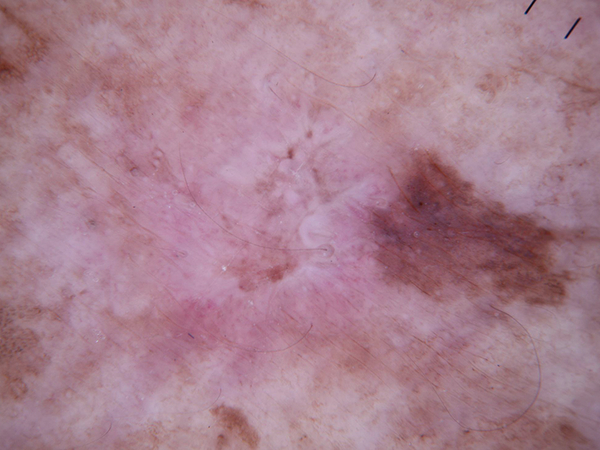

In [35]:
train_ds[0]["image"]

### Image Tranformations

- All images must be the same size for the model to process them in batches. 
- We also need to convert them to PyTorch Tensors and normalize them.
- Normalizing with mean and std of (0.5, 0.5, 0.5) scales the pixel values from [0, 1] to [-1, 1].
- This helps the model train more stably.

Why we need to normalize images using mean as 0.5 and std as 0.5? 

The reason is that pixel values in images typically range from 0 to 255. When we convert these pixel values to a range of [0, 1] by dividing by 255, the mean of the pixel values tends to be around 0.5 for many natural images. By normalizing with a mean of 0.5 and a standard deviation of 0.5, we effectively center the pixel values around 0 and scale them to fall within the range of [-1, 1]. This normalization helps improve the convergence and stability of the training process for neural networks.


In [36]:
from torchvision import transforms

In [37]:
IMG_SIZE = 224 # Image size for ResNet50

data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Resnet50 normalization. ResNet was trained on ImageNet with specific normalization values. We must use the same mean and std for best results!
])

## 2. Pytorch Dataset and DataLoader

A pytorch Dataset is a custom class that allows us to load and preprocess our data efficiently. It defines how to access individual data samples and their corresponding labels. It typically implements two main methods: 
1. `__len__` to return the total number of samples in the dataset, and 
2. `__getitem__` to retrieve a specific sample and its label based on an index. 

This class is essential for organizing and managing data in a way that can be easily fed into a PyTorch DataLoader for batching and shuffling during training.

It's like our data loader will call the `__getitem__` method to get a sample and its label whenever it needs to create a batch for training or evaluation.

In [38]:
import torch
from torch.utils.data import Dataset

In [39]:
class SkinLesionDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
        # Create a mapping from string labels to integer indices
        self.label_map = {"benign": 0, "malignant": 1}

    def __len__(self):
        # This should return the total number of samples in the dataset.
        return len(self.dataset)

    def __getitem__(self, idx):
        # This method is responsible for getting a single sample and its label.
        item = self.dataset[idx]
        
        # Get the image and apply transformations
        image = item['image']
        if self.transform:
            image = self.transform(image) # this will call our defined transformations that we defined earlier
        
        # Get the label and convert it to an integer
        label_str = item['label']
        label_int = self.label_map[label_str]
        
        # PyTorch loss functions expect labels to be Tensors as well and it should be of type Long for classification tasks
        label = torch.tensor(label_int, dtype=torch.long)
        
        return image, label

In [40]:
# Create instances of our custom dataset for both training and testing
train_pytorch_ds = SkinLesionDataset(dataset['train'], transform=data_transforms)
test_pytorch_ds = SkinLesionDataset(dataset['test'], transform=data_transforms)

print(f"Number of training samples: {len(train_pytorch_ds)}")
print(f"Number of testing samples: {len(test_pytorch_ds)}")

# Let's check a sample to see if it works
img, label = train_pytorch_ds[0]
print(f"\nSample check:")
print(f"Image shape: {img.shape}") # Should be [3, IMG_SIZE, IMG_SIZE]
print(f"Label: {label}")           # Should be 0 or 1

Number of training samples: 2000
Number of testing samples: 1511

Sample check:
Image shape: torch.Size([3, 224, 224])
Label: 0


### DataLoader

In [41]:
from torch.utils.data import DataLoader

In [42]:
BATCH_SIZE = 32 # Number of samples to process in each step. You can adjust this based on your GPU memory. The larger the batch size, the faster the training (up to a point) but it also requires more memory.

train_loader = DataLoader(train_pytorch_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_pytorch_ds, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test data.

# Let's inspect a single batch to see its shape
images, labels = next(iter(train_loader))
print(f"\nA single batch:")
print(f"Images batch shape: {images.shape}") # [BATCH_SIZE, Channels, Height, Width]
print(f"Labels batch shape: {labels.shape}") # [BATCH_SIZE]


A single batch:
Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


## 3. Load Pretrained Resnet50 Model

In [43]:
from torchvision import models
from torch import nn

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [45]:
# Load pre-trained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [46]:
# Print original model structure
print("Original ResNet18 Final Layer:")
print(model.fc)

Original ResNet18 Final Layer:
Linear(in_features=512, out_features=1000, bias=True)


In [47]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: benign and malignant

In [48]:
print("Modified ResNet18 Final Layer:")
print(model.fc)

Modified ResNet18 Final Layer:
Linear(in_features=512, out_features=2, bias=True)


In [49]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB")

Total parameters: 11,177,538
Trainable parameters: 11,177,538
Model size: 42.64 MB


## 4. Model Training

### 4.1 Fine Tuning the Model

In [50]:
loss_fn = nn.CrossEntropyLoss() # Best for multi-class/binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Lower learning rate for fine-tuning pretrained models

In [51]:
NUM_EPOCHS = 2 # We will just train for few epochs as we are fine-tuning a pretrained model

# Lists to track losses for plotting
train_losses = []
train_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train() # Put the model in training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print('-'*60)

    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the device
        images, labels = images.to(device), labels.to(device)
        
        # 1. Forward pass
        outputs = model(images)
        
        # 2. Calculate loss
        loss = loss_fn(outputs, labels)
        
        # 3. Zero the gradients
        optimizer.zero_grad()
        
        # 4. Backward pass
        loss.backward()
        
        # 5. Update weights
        optimizer.step()
        
        # calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            avg_loss = running_loss / (batch_idx + 1)
            avg_acc = (correct_predictions / total_samples) * 100
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}] | "
                    f"Loss: {loss.item():.4f} | "
                    f"Accuracy: {avg_acc:.2f}%")
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = (correct_predictions / total_samples) * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    print(f"\nEpoch {epoch+1} Summary: Avg Loss: {epoch_loss:.4f} | Avg Accuracy: {epoch_acc:.2f}%")

print("\nFinished Training!")

Epoch 1/2
------------------------------------------------------------
  Batch [10/63] | Loss: 0.5630 | Accuracy: 72.81%
  Batch [20/63] | Loss: 0.3806 | Accuracy: 75.00%
  Batch [30/63] | Loss: 0.3759 | Accuracy: 76.15%
  Batch [40/63] | Loss: 0.4598 | Accuracy: 77.50%
  Batch [50/63] | Loss: 0.3873 | Accuracy: 77.88%
  Batch [60/63] | Loss: 0.3207 | Accuracy: 78.39%

Epoch 1 Summary: Avg Loss: 0.4418 | Avg Accuracy: 78.15%
Epoch 2/2
------------------------------------------------------------
  Batch [10/63] | Loss: 0.3116 | Accuracy: 94.06%
  Batch [20/63] | Loss: 0.1142 | Accuracy: 94.22%
  Batch [30/63] | Loss: 0.1364 | Accuracy: 94.27%
  Batch [40/63] | Loss: 0.0754 | Accuracy: 94.14%
  Batch [50/63] | Loss: 0.1574 | Accuracy: 94.44%
  Batch [60/63] | Loss: 0.0855 | Accuracy: 94.53%

Epoch 2 Summary: Avg Loss: 0.1628 | Avg Accuracy: 94.70%

Finished Training!


####  Model Evaluation

In [54]:
model.eval() # Put the model in evaluation mode (important!)
correct_predictions = 0
total_samples = 0


with torch.no_grad(): # We don't need to calculate gradients during evaluation
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        
        # The output is logits. We get the predicted class by finding the index of the max logit.
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Print progress every 10 batches (adjust as needed)
        if (batch_idx + 1) % 5 == 0:
            current_accuracy = (correct_predictions / total_samples) * 100
            print(f"  Batch [{batch_idx+1}/{len(test_loader)}] | "
                f"Current Accuracy: {current_accuracy:.2f}%")

accuracy = (correct_predictions / total_samples) * 100
print("\n" + "="*60)
print("📊 FINAL RESULTS")
print("="*60)
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Correct Predictions: {correct_predictions}/{total_samples}")
print("="*60)

  Batch [5/48] | Current Accuracy: 83.12%
  Batch [10/48] | Current Accuracy: 84.38%
  Batch [15/48] | Current Accuracy: 83.33%
  Batch [20/48] | Current Accuracy: 84.22%
  Batch [25/48] | Current Accuracy: 83.62%
  Batch [30/48] | Current Accuracy: 84.48%
  Batch [35/48] | Current Accuracy: 83.93%
  Batch [40/48] | Current Accuracy: 82.34%
  Batch [45/48] | Current Accuracy: 81.18%

📊 FINAL RESULTS
Test Accuracy: 80.74%
Correct Predictions: 1220/1511


### 4.2 Feature Extraction

In [56]:
# Load fresh resnet18 model
model_frozen = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [57]:
# freeze all layers
for param in model_frozen.parameters():
    param.requires_grad = False

# replace the final layer (this will be trainable)
num_features = model_frozen.fc.in_features
model_frozen.fc = nn.Linear(num_features, 2)  # 2 classes:

model_frozen = model_frozen.to(device)

In [58]:
total_params = sum(p.numel() for p in model_frozen.parameters())
trainable_params = sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 11,177,538
Trainable parameters: 1,026
Frozen parameters: 11,176,512


In [59]:
loss_fn_frozen = nn.CrossEntropyLoss() # Best for multi-class/binary classification
optimizer_frozen = torch.optim.Adam(model_frozen.parameters(), lr=0.001) # Can use a bit higher learning rate since we are only training the final layer

In [60]:
NUM_EPOCHS_FROZEN = 2

for epoch in range(NUM_EPOCHS_FROZEN):
    model_frozen.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_FROZEN}")
    print("-"*60)
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model_frozen(images)
        loss = loss_fn_frozen(outputs, labels)
        
        # Backward pass
        optimizer_frozen.zero_grad()
        loss.backward()
        optimizer_frozen.step()
        
        # Track metrics
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}] | "
                    f"Loss: {loss.item():.4f} | "
                    f"Acc: {(correct/total)*100:.2f}%")
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = (correct / total) * 100
    
    print(f"\nEpoch {epoch+1} Summary: Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")


Epoch 1/2
------------------------------------------------------------
  Batch [10/63] | Loss: 0.6527 | Acc: 55.00%
  Batch [20/63] | Loss: 0.4442 | Acc: 60.78%
  Batch [30/63] | Loss: 0.4841 | Acc: 63.65%
  Batch [40/63] | Loss: 0.5167 | Acc: 66.95%
  Batch [50/63] | Loss: 0.5334 | Acc: 68.12%
  Batch [60/63] | Loss: 0.5268 | Acc: 68.96%

Epoch 1 Summary: Loss: 0.5643 | Acc: 69.35%

Epoch 2/2
------------------------------------------------------------
  Batch [10/63] | Loss: 0.4349 | Acc: 74.69%
  Batch [20/63] | Loss: 0.4740 | Acc: 75.62%
  Batch [30/63] | Loss: 0.4509 | Acc: 75.73%
  Batch [40/63] | Loss: 0.4485 | Acc: 76.48%
  Batch [50/63] | Loss: 0.4055 | Acc: 77.19%
  Batch [60/63] | Loss: 0.2658 | Acc: 77.76%

Epoch 2 Summary: Loss: 0.4617 | Acc: 77.80%


In [61]:
model_frozen.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_frozen(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

frozen_accuracy = (correct / total) * 100

print(f"Test Accuracy: {frozen_accuracy:.2f}%")


Test Accuracy: 68.10%


## 6. Model Saving

In [55]:
# --- Save the Model's State Dictionary ---
MODEL_SAVE_PATH = "simple_cnn_skin_lesion.pt"
torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"\nModel saved to {MODEL_SAVE_PATH}")


Model saved to simple_cnn_skin_lesion.pt
